In [1]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter,convolve
import matplotlib.pyplot as plt
from scipy import where
import cv2

/var/folders/nb/91ndyn8522572mnr6hfxzk540000gn/T/ipykernel_5244/2409616582.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter,convolve
/var/folders/nb/91ndyn8522572mnr6hfxzk540000gn/T/ipykernel_5244/2409616582.py:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter,convolve


In [2]:
DPI = 120

### load the image

Text(0.5, 1.0, 'Input image')

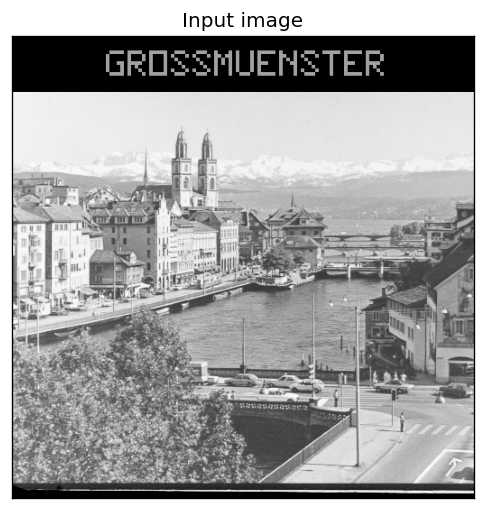

In [3]:
input_img=cv2.imread('inputs/grossmuenster.png', 0).astype('float')
plt.figure(figsize=(5, 5),dpi=DPI)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

### Gaussian blur the image

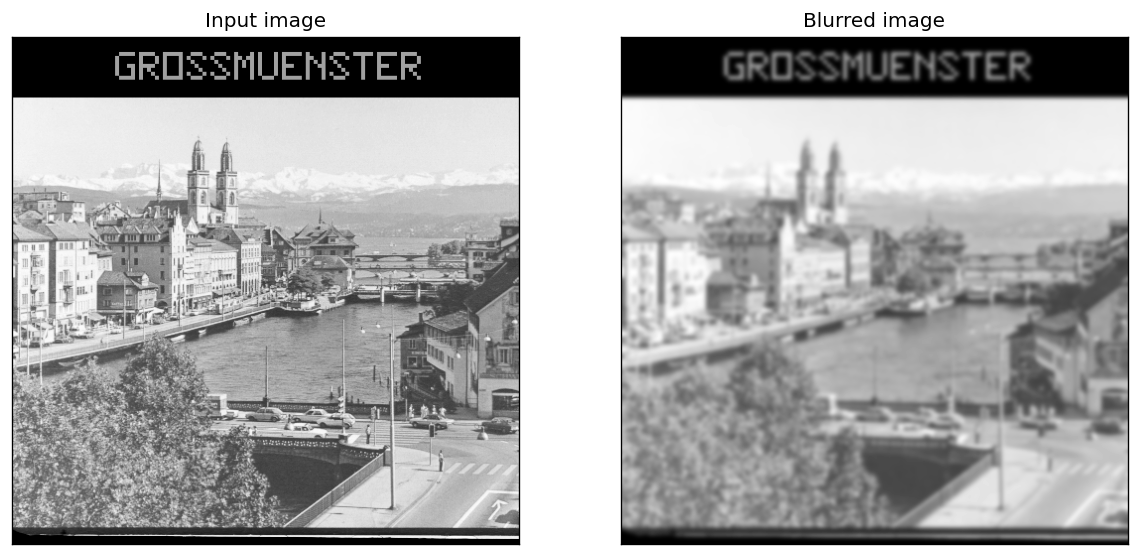

In [30]:
## TODO
blurred_img = gaussian_filter(input_img, sigma=2.2)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(blurred_img, cmap=plt.cm.gray)
plt.title('Blurred image')
plt.show()

### Use Sobel filter to compute gradient along x and y

In [31]:
## TODO
sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
I_x = convolve(blurred_img, sobel_kernel)
I_y = convolve(blurred_img, sobel_kernel.T)

### Compute gradient magnitude and direction

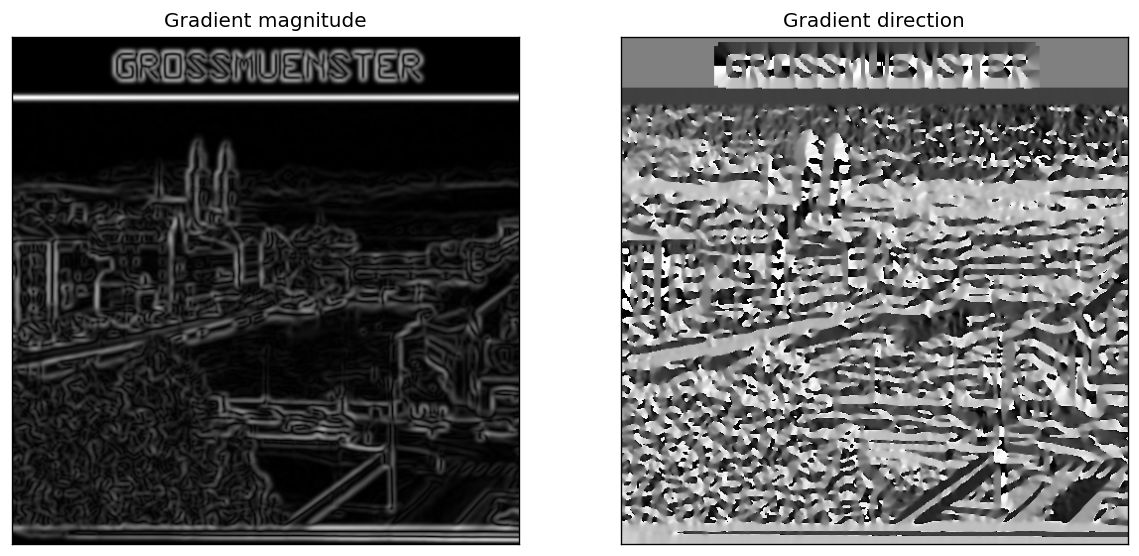

In [38]:
## TODO
magnitude = np.sqrt(I_x**2 + I_y**2)
direction = np.arctan2(I_y, I_x)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(magnitude, cmap = 'gray')
plt.title('Gradient magnitude')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(direction, cmap=plt.cm.gray)
plt.title('Gradient direction')
plt.show()

### Threshold the edges

In [42]:
## TODO
thresh = 150
thresholdEdges = (magnitude > thresh)

### Apply NMS

In [43]:
## TODO
edges = thresholdEdges

### Visualise the Canny edges

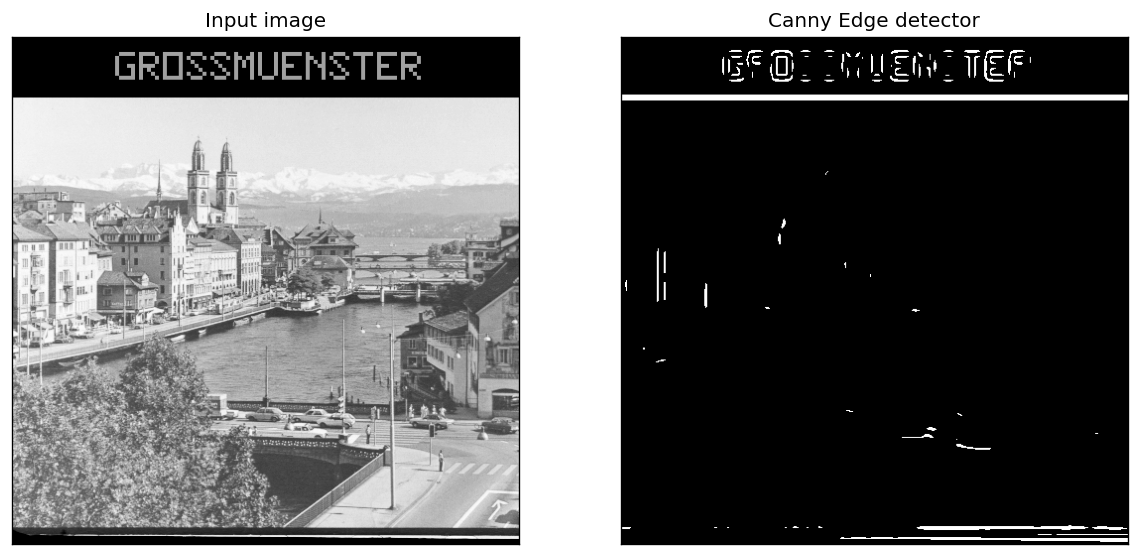

In [44]:
plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(edges, cmap=plt.cm.gray)
plt.title('Canny Edge detector')
plt.show()

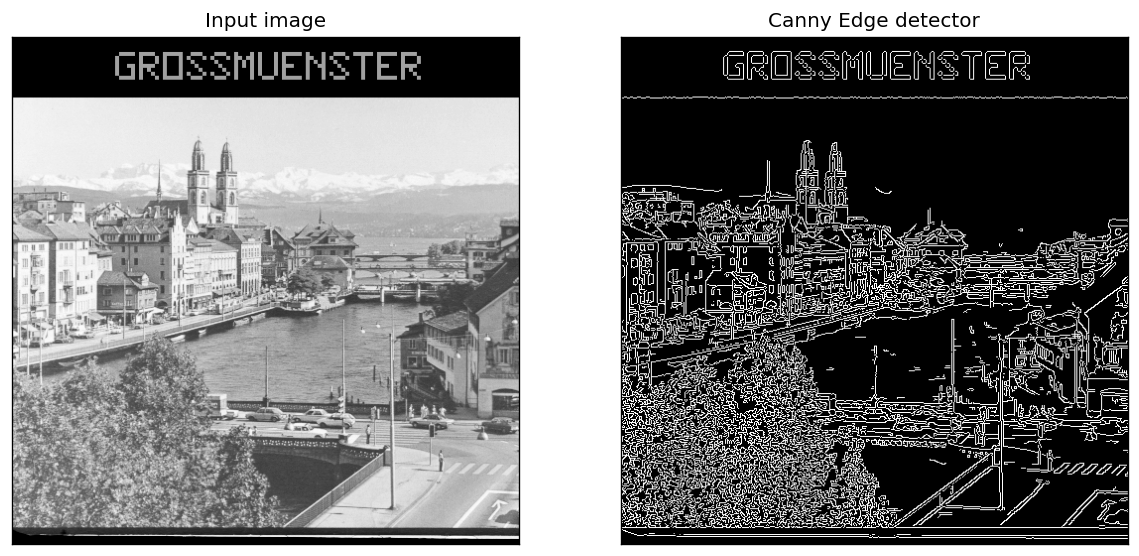

In [33]:
edges_canny = cv2.Canny(input_img.astype('uint8'), 100, 200)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(edges_canny, cmap=plt.cm.gray)
plt.title('Canny Edge detector')
plt.show()